<h1><center>TP IOT:</center></h1>
<h1><center>Prédiction de la localisation</center></h1>

<h2><center>Colin PARELLIER, Olivier SANS, Charles THEROND</center></h2>


**Dans ce rapport, nous présentons notre travail visant à prédire la géolocalisation de devices à partir de bases détectant leurs messages. La solution généralement utilisée pour traiter ce genre de problème est la triangulation. En revanche, pour des devices très légers, la précision des informations transmises n'est pas suffisante pour ce type de technique. C'est pourquoi, nous abordons une approche prédictive utilisant des algorithmes de machine learning.**

**Notes:**
* **Nous avons monté un cluster Spark sur les machines de l'école afin de fixer les hyperparamètres de nos algorithmes. Nous avons ajouté le code utilisé (**`Grid Search`**) et commenter leur lancement pour éviter l'affichage d'erreurs.** 
* **Durant la phase d'exploration des données, un gros travail sur la visualisation a été effectué. Ce travail ne peut pas être visualiser sans installation des librairies proposées ci-dessous (il suffit seulement de décommenter pour lancer l'installation de toutes les librairies).**


**Bonne lecture et merci par avance pour votre temps.**

# Import des librairies additionnelles (à décommenter)

In [1]:
import sys
envs = !conda env list
active_env = list(filter(lambda s: '*' in str(s), envs))[0]
env_name = str(active_env).split()[0]
print( env_name)
#=======================================================================
# DASH
#! pip install plotly
#! pip install dash
#! pip install dash-html-components
#! pip install dash-core-components
#! pip install dash-table
#
# Visualisation de dash dans jupyter
#
#! pip install aiohttp
#! pip install django_plotly_dash
#! pip install jupyter_plotly_dash
#
# Autre
#
#!pip install  geopy
print("fin d'installation ")
# Set credential
import plotly
plotly.tools.set_credentials_file(username='telecommsbgd2', api_key='vycTMoJ16qDZEdUWiOiC')

python36
fin d'installation 


In [2]:
# Dans le cadre de la selection des hyperparamètres de nos modèles, nous avons monté un cluster spark pour distribuer les calculs.
# La librairie spark_sklearn permet l'integration des algorithmes de sklearn (absents dans la librairie mllib)
#from spark_sklearn import GridSearchCV 

#Package classique
import numpy as np
import pandas as pd
import datetime
from datetime import datetime as dt


# calcul de distance
from geopy.distance import vincenty


#Package affichage
from jupyter_plotly_dash import JupyterDash
import dash
from dash.dependencies import Input, Output,State
import dash_core_components as dcc
import dash_html_components as html
import dash_table as dtt
import plotly.graph_objs as go
import multiprocessing
import matplotlib.pyplot as plt



# Package machine learning
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
import xgboost as xgb
from pprint import pprint
from time import time 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Import des jeux de données

In [3]:
df_mess_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_train_list.csv')
df_mess_test = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_test_list.csv')
pos_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/pos_train_list.csv')
print(df_mess_train.head(5))

                     messid  bsid       did  nseq   rssi       time_ux  \
0  573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5 -121.5  1.463546e+12   
1  573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0 -125.0  1.463546e+12   
2  573bf3533e952e19126b256a  2605  473335.0   1.0 -134.0  1.463547e+12   
3  573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.0  1.463553e+12   
4  573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.0  1.463553e+12   

      bs_lat      bs_lng  
0  39.617794 -104.954917  
1  39.677251 -104.952721  
2  39.612745 -105.008827  
3  39.797969 -105.073460  
4  39.723151 -104.956216  


**Pour la partie exploration, Nous joignons les tables** ```def_mess_train``` **et** ```pos_train``` **dans la table** ```df``` **.**

In [4]:
df = df_mess_train.merge(pos_train, how='left', left_index=True,right_index=True)
# On enleve les valeurs abérente pour la visualisation
df = df.drop(df[(df.bs_lng >55) ].index)

In [5]:
# Récuperation des bsid sur le jeu de train
basepos = df_mess_train[['bsid','bs_lat','bs_lng']]\
    .groupby(by='bsid')\
    .agg({'bs_lat':'mean','bs_lng':'mean'})\
    .sort_index()\
    .reset_index(drop=False)
#Récuperation des bsid sur le jeu de test
basepos2 = df_mess_test[['bsid','bs_lat','bs_lng']]\
    .groupby(by='bsid')\
    .agg({'bs_lat':'mean','bs_lng':'mean'})\
    .sort_index()\
    .reset_index(drop=False)

In [6]:
bsid_tab=basepos.append(basepos2, ignore_index=True)
bsid_tab['bsid']=pd.to_numeric(bsid_tab.bsid.values)
bsid_tab.drop_duplicates(subset='bsid',inplace=True)
bsid_tab.reset_index(drop=False)

,index,bsid,bs_lat,bs_lng
0,0,879,39.739013,-105.392793
1,1,911,42.324279,-107.159505
2,2,921,42.131222,-107.008741
3,3,944,41.424900,-106.143919
4,4,980,38.997730,-104.684275
5,5,1012,39.898566,-105.210042
6,6,1086,39.973995,-104.891717
7,7,1092,64.300000,-68.500000
8,8,1120,40.464651,-105.951819
9,9,1148,36.555938,-102.548384


# Exploration des données

**Afin d'effectuer une exploration dynamique et intuitive, observons nos données au travers d'un dashboard.**

In [7]:
app = JupyterDash('Visualisation donnée gps')
app.width="1300px"
app.height="900px"

# fonction et application pour la visualisation 
def getdid(dff):
    did=[]
    for val in dff.did.unique():
        tmp={}
        tmp['label']=val
        tmp['value']=val
        did.append(tmp)
    
    return did
df['time']=pd.to_datetime(df.time_ux, unit='ms')
df['text']=" Date "+df["time"].map(str)+" Message ID " + df["messid"].astype(str)

mapbox_access_token = 'pk.eyJ1IjoiY2h1emUiLCJhIjoiY2pxMHRsY3IzMG9lMjQ4cWprZWJkZTBxMiJ9.gKc50IpMQM2e4skq2NskHw'
app.layout = html.Div([
    html.Link(href='https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css',rel='stylesheet'),
    html.Div(className="row",children=[
        html.Div(className="col-sm-10",children=[
            dcc.Graph(id='visualisation'),
            html.Div(className="row",children=[
                html.Div(className="col-sm-7",children=[
                    dcc.Graph(id='visualisation2'),
                ]),
                html.Div(className="col-sm-5",children=[
                    html.H2("Device ID"),
                    dcc.Dropdown(
                        id='devicesID',
                        options=getdid(df),
                        multi=True,
                        value=df.did[0]
                    ),
                    html.Div([
                    ],id='test'),
                    html.P('Pour mettre à jour le second graphe clicker sur un point sur la carte de positionnement des devices')
                ])
            ]),
        ]),
        html.Div(className="col-sm-2",children=[
            html.Div([
                dcc.RangeSlider(
                    id='timechoice',
                    count=1,
                    min=-5,
                    max=10,
                    step=0.5,
                    value=[-3, 7]
                )
            ],id='choixslider',style={'height':'95vh','width':'100%','margin-top':'2.5vh'}),
        ])
    ])
])

# maj du slider temporel
@app.callback(
    Output('choixslider', 'children'),
    [Input('devicesID','value')]
)
def range_time(typeD):
    #calcul lie au composant
    q=""
    if type(typeD)==list:
        for device in typeD[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(typeD[-1])+"'"
    else:
        q+="did =='"+str(typeD)+"'"
    rq=df.query(q)
    n = len(rq.time_ux.unique())
    # "beaute du slider"
    mark={}
    step_dot=int(n/10.0)
    for nn in range(n):
        if nn%step_dot==0:
            print(nn)
            print(rq.time.astype(str).unique()[nn])
            mark[str(nn)]=rq.time.astype(str).unique()[nn]
    mark[n]=rq.time.astype(str).unique()[n-1]
    # mise en place du composant
    return [dcc.RangeSlider(
        id='timechoice',
        min=0,
        max=n,
        vertical=True,
        marks=mark,
        value=[int(n*0.25),int(n*0.75)]
    )]
    

#Maj du graph principale
@app.callback(
    dash.dependencies.Output('visualisation', 'figure'),
    [Input('timechoice', 'value'),
     Input('devicesID','value')])
def update_vis(timechoice,DID):
    # requettage sur table des devices à afficher sur une période choisie
    q=""
    if type(DID)==list:
        for device in DID[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(DID[-1])+"'"
    else:
        q+="did =='"+str(DID)+"'"
    devicefil = df.query(q)

    tux_unique = list(devicefil.time_ux.unique())
    q2=""
    if type(timechoice)==list:
        timee=tux_unique[timechoice[0]:timechoice[1]]
        q2+="time_ux>="+str(min(timee))+" and time_ux<="+str(max(timee))
    else:
        timee=tux_unique[timechoice]
        q2+="time_ux=="+str((timee))
    selection=devicefil.query(q2)
    
    # mise en conformite du device ID
    if type(DID)!=list:
        valnum=DID
        DID=[]
        DID.append(valnum)
        
    # display des bases de geolocalisation
    traces = []
    traces.append(go.Scattermapbox(
        lat=bsid_tab.bs_lat.values,
        lon=bsid_tab.bs_lng.values,
        mode='markers',
        name="Stations",
        opacity=0.7,
        marker = dict(
            symbol="information"
        ),
        text=basepos.index.values
        ))
        
    # display des devices
    for deviceID in DID:
        traces.append(go.Scattermapbox(
            lat=selection[(selection.did==deviceID)].lat.values,
            lon=selection[(selection.did==deviceID)].lng.values,
            mode='markers',
            opacity=0.7,
            marker = dict(
                size = 10,
            ),
            name=deviceID,
            text=selection[(selection.did==deviceID)].text.values,
        ))

    # Design
    layout = dict(
        title = 'Positionnement des devices',
        showlegend = True,
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=np.mean(selection.lat.values),
                lon=np.mean(selection.lng.values)
            ),
            pitch=0,
            zoom=9
        ),
        margin={'l': 10, 'b': 10, 't': 30, 'r': 10},

    )
    return {
        'data': traces,
        'layout': layout
    }

# Maj du second graph via message id
@app.callback(
    dash.dependencies.Output('visualisation2', 'figure'),
    [Input('visualisation', 'clickData')])
def update_vis2(hoverData):
    try:
        hover=hoverData['points'][0]["text"].split(' ')[-1]
        q="messid =='"+str(hover)+"'"
        devicefil = df.query(q)
        traces = []
        
        for deviceID in devicefil[['lat','lng','bs_lat','bs_lng','rssi','bsid']].values:
            txt='base id '+str(deviceID[-1])
            traces.append(go.Scattermapbox(
                showlegend=True,
                lat=[deviceID[0],deviceID[2]],
                lon=[deviceID[1],deviceID[3]],
                mode='markers+lines',
                opacity=0.7,
                marker = dict(
                    size = 10,
                ),
                text=deviceID[4],
                name=txt,
            ))


        # Design
        layout = dict(
            title = 'messid = '+str(hover),
            showlegend = True,
            mapbox=dict(
                accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(
                    lat=np.mean(devicefil.lat.values),
                    lon=np.mean(devicefil.lng.values)
                ),
                pitch=0,
                zoom=12
            ),
            margin={'l': 10, 'b': 10, 't': 30, 'r': 10},
        )
        
        return {
            'data': traces,
            'layout': layout
        }
    except:
        return {}




# Test des composants ajoutés
@app.callback(
    Output('test', 'children'),
    [Input('timechoice', 'value'),
     Input('devicesID','value')]
)
def test(timechoice,typeD):
    q=""
    if type(typeD)==list:
        for device in typeD[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(typeD[-1])+"'"
    else:
        q+="did =='"+str(typeD)+"'"
    rq=df.query(q)
    text = list(rq.time_ux.unique())
    q2=""
    if type(timechoice)==list:
        timee=text[timechoice[0]:timechoice[1]]
        q2+="time_ux>="+str(min(timee))+" and time_ux<="+str(max(timee))
    else:
        timee=text[timechoice]
        q2+="time_ux=="+str((timee))
    return [html.P(str()+"    "+str(q))]



app

<P style='display:inline'> 
<img src="1base.png" style="width:40%"/>
<img src="2bases.png" style="width:40%"/>
</P>

**Comme le montre les images ci-dessus, lorsqu'on utilise des méthodes classiques de géolocalisation (tel que la triangulation), si on possède moins de 3 bases, il n'est pas possible de calculer la position d'un message:**  
 * **Dans l'image à gauche, si le message est reçu uniquement par une base alors sa position théorique peut prendre n'importe quelle valeur sur l'arc de cercle tracé en bleu.**
 * **Dans l'image à droite, si le message est reçu par deux bases alors sa position se situe autour de l'une des intersections des deux arcs de cercles.**

<P style='display:inline'> 
<img src="3bases.png" style="width:40%"/>
<img src="Xbases.png" style="width:40%"/>
</P>

**On voit bien que dès que le message est reçu par trois bases ou plus, il n'a plus qu'un point d'intersection correspondant à la position du device.**

<img src='baseab.png'>

**On peut observer la présence de bases "mal géolocalisées". En effet, il y a 27 bases (comme indiqué par la requête ci-dessous) positionnées au Canada alors que le reste du dataset est situé aux Etats Unis.**

In [8]:
print(f"Nombre de bases au Canada : {df.query('bs_lat > 60')['bsid'].nunique()}")

Nombre de bases au Canada : 27


> **Note :**
>
> **Le modèle que nous utilisons par la suite ne tenant pas compte de la position des bases (lat et lng) et les rssi associés à ces bases restant cohérent, nous avons décidé de garder ces bases.**

In [9]:
Analyse=df.groupby('messid').count().query('rssi<5')[['rssi','nseq']].groupby('rssi').count().reset_index(drop=False)
Analyse.columns=['Nb de base pour un messid', 'count']
Analyse

,Nb de base pour un messid,count
0,1,1329
1,2,953
2,3,875
3,4,494


**Le dataframe ci-dessus nous permet de constater qu'un grand nombre de messages ne sont recus que par une seule base. Dans le cadre d'une triangulation d'un message, la géolocalosation ne serait pas possible ou très incertaine. On peut alors se poser la question de garder ces messages pour nos modèles. Cependant, il y important de noter que ces messages véhiculent de l'information. Après vérification, ces valeurs ne sont globalement pas aberrantes. Il n'y a donc pas de raison que notre modèle ne tiennent pas compte de cette information durant son entrainement.**

## Suppression des variables "non pertinantes"

* **Nous supprimons la variable** ```did``` **(id du device). En effet, l'apprentissage des routines d'un périphérique limiterait la flexibilité du modèle.**

* **N'ayant que peu d'information sur** ```nseq``` **, nous avons décidé de ne pas l'incorporer à notre modèle par manque de compréhension.**

* **Enfin la derniere variable considérée comme non pertinante est la colonne** ```time_ux``` **. En effet, son intégration directe au modèle peut entrainer un "sur-apprentissage" en prédisant la position d'émission d'un message à l'horaire en question.** 
<div style='text-align:center'>
<img src='same.png' style='width:40%'>
</div>  

**Note:**
* **La variable** `time_ux` **peut, en revanche, devenir intéressante dans le cadre d'une aggrégation temporelle. Nous décrivons et étudions cette possibilité plus tard dans le rapport.** 

## Démarche pour la construction de notre matrice 
**Une difficulté particulière du jeu de donnée réside dans les observations redondantes. En effet, un même message apparait autant de fois qu'il est reçu par une base. Ce nombre varie selon les messages. L'aggrégation des différentes occurences d'un message produirait un problème de dimension non géré nativement par la plus part des algorithmes de machine learning (à l'exception des réseaux de neuronnes).**

**Afin de s'affranchir du problème de dimensions souligné précédemment, nous avons élaborer un modèle de type "hot encoder" où les features représentent chaque base (train et test) et les observations correspondent à chaque message aggrégé. La grosse hypothèse sous-jacente à ce modèle réside dans le fait qu'il est nécessaire que les bases contenues dans le jeu de test soient globalement les mêmes que celles du jeu d'entrainement. En effet, la représentation des bases sous forme de features implique qu'on ne puisse pas généraliser l'apprentissage aux bases non connues du jeu d'entrainement (une base représentant une nouvelle variable).**

**Dans un contexte industriel, il est donc nécessaire d'entrainer le modèle sur toutes les bases connues. Nous pouvons raisonnablement considérer que ce modèle serait robuste car le nombre de bases évoluera lentement vu les contraintes d'installation de celles-ci.**

**La cellule suivante confirme cette hypothèse:** 

In [10]:
b1=0
b2=0
for ind in basepos.bsid.unique():
    if ind in basepos2.bsid.unique():
        b1+=1
for ind in basepos2.bsid.unique():       
    if ind in basepos.bsid.unique():
        b2+=1
    

print( "Le nombre de base unique du jeu de train est",basepos.bsid.nunique(),", il comporte",\
      b1,"bases en commun avec l'autre jeu de données")
print( "Le nombre de base unique du jeu de test est",basepos2.bsid.nunique(),", il comporte",\
      b2,"bases en commun avec l'autre jeu de données")

Le nombre de base unique du jeu de train est 251 , il comporte 160 bases en commun avec l'autre jeu de données
Le nombre de base unique du jeu de test est 168 , il comporte 160 bases en commun avec l'autre jeu de données


**Seules 8 des 168 bases du jeu de test ne sont pas contenues dans le jeu d'entrainement. Notre choix de modélisation reste donc cohérent au vu de la fonction de score imposée. En effet, le score est égal à la plus mauvaise prédiction en distance des 80 percentiles de position prédites.**

**Initialement, notre modèle tenait simplement compte de la réception d'un message par une base (ie, 1 si réception 0 sinon). Nous avons défini plusieurs variantes visant à prendre en compte plus d'information. Une de ces variantes consistait à pondérer la réception d'un message par son** ```rssi``` **. La variable** ```rssi``` **correspond à la puissance reçu par une base (en dbm). Cette mesure peut se rapprocher à une mesure de la distance entre la base et la position où le message a été émis (de nombreuses applications en géolocalisation indoor utilisent cette mesure). Ses valeurs sont continues et évoluent sur une échelle logarithmique. Dans notre cas, la précision de ses valeurs n'est pas suffisante pour permettre une bonne estimation de la distance. En revanche, elle permet tout de même un gain d'information par rapport à une valeur booléenne.**


**Du fait de notre** `hot-encoding` **, la variable** `rssi` **est traitée comme une variable catégorielle (chaque valeur représente une catégorie). La perte de continuité de la variable peut se lisser avec l'augmentation de la plage de valeurs sur chaque feature. Nous traitons ce problème par la suite.**

> A noter : Si l'on souhaite un modèle plus flexible à l'intégration de nouvelle base, le "hashing trick" est une solution. Cette méthode de modélisation est élaborée sur une matrice de grande dimension pouvant absorber de nouvelle observation, ici périphérique, avec de nouvelle variables catérgorielles, ici, des bases, sans avoir à redéfinir toute la matrice de variable et donc à ré-entrainer tout le modèle. Ce n'est pas une voie empruntée ici car il n'est pas demandé un modèle robuste à l'évolution du nombre de base dans le temps.

**Une autre transformation que nous avons envisagé est l'aggregation temporelle à l'aide de la variable** ```time_ux``` **. En effet, il est peu probable que le device associé à un message se déplace drastiquement dans la seconde. L'idée consiste à fusionner deux (voire plusieurs) messages lorsqu'ils ont été émis par un même device dans un court laps de temps. L'objectif est de renforcer la prédiction des messages n'ayant été réceptionnés que par un faible nombre de bases.**

## Aggrégation temporelle


In [11]:
#calcul de df

# dictionnaire des bsid
bsiddic = list(bsid_tab['bsid'].unique())
def bsid_index(x):
    return bsiddic.index(x)
# dictionnaire des messid
middic = list(df['messid'].unique())
def messid_index(x):
    return middic.index(x)
# dictionnaire des devices id
list_did = list(df['did'].unique())
def did_index(x):
    return list_did.index(x)


def set_X(df,step=500,verbose=False):
    '''
    Input:
    step -> temps en ms pour aggregation par defaut il vaut 500 ms car on ne se deplace pas drastiquement en 0.5 seconde
    verbose -> boolean pour mieux suivre les transformations de l'algorithme
    
    Output:
    Xval -> nouvelle matrice X calculé en tenant compte de l'aggregation
    Ylat et Ylong  qui sont les valeurs a prédire.
    '''
    df['time']=pd.to_datetime(df.time_ux, unit='ms')
    combinaison_dic=df.groupby(['messid','did']).mean().sort_values(by='did',ascending=False).reset_index(drop=False)[['messid','did','time_ux']].values
    #init des valeurs qu'on cherches à calculer
    Xval=np.zeros((len(combinaison_dic),len(bsiddic)),dtype=float)

    did = ''
    for i in range(len(combinaison_dic)):
        # afin d'optimiser le requetage
        if did != combinaison_dic[i][1]:
            did =combinaison_dic[i][1]
            voisin=df[['messid','bsid','did','rssi','time']].query("did =='"+str(combinaison_dic[i][1])+"'")
        # recherches des potentielles valeurs a prendre compte pour notre message id
        voisin['timetmp']=pd.to_datetime(combinaison_dic[i][2], unit='ms')
        mask=abs(voisin.timetmp-voisin.time)<datetime.timedelta(milliseconds=step)
        valeurX=voisin[mask].groupby(by='bsid').agg({'rssi':'mean'}).reset_index(drop=False).values
        # Pour plus de détail sur les changements
        if verbose & (len(valeurX)!=len(voisin[voisin.messid==combinaison_dic[i][0]])):
            print("Message id concerné",combinaison_dic[i][0])
            print("Apres aggregation, le nouveau nombre de valeurs hot-encoded est",len(valeurX))
            print("Nombre de valeurs anciennement hot-encoded",len(voisin[voisin.messid==combinaison_dic[i][0]]))
        #maj de X pour le messid correspondant
        for ind, val in valeurX:
            Xval[messid_index(combinaison_dic[i][0])][bsid_index(int(ind))]=val
    return Xval
 
print('''Par intervalle de 1 heure
Information sur le changement de position d'un device ''') 
XP=set_X(df_mess_train,60000,True)



Par intervalle de 1 heure
Information sur le changement de position d'un device 
Message id concerné 577412b9e541cd7f54c86ab4
Apres aggregation, le nouveau nombre de valeurs hot-encoded est 13
Nombre de valeurs anciennement hot-encoded 11
Message id concerné 577412e4e541cd7f54c8855f
Apres aggregation, le nouveau nombre de valeurs hot-encoded est 13
Nombre de valeurs anciennement hot-encoded 7


**Dans le cadre du sujet, nous ne possédons pas assez de données pour que l'aggregation temporelle ait un réel impact sur notre modèle. Même en aggregeant les données sur 1h, seul deux messages bénéficient de la méthode. Sur cette plage de temps, le changement de position du device est trop important pour prédire quoi que ce soit.**

### Labélisation du ```rssi```

**Nous labelisons la variable** ```rssi``` **par des intervalles de valeurs dans l'objectif de rendre plus pertinent la catégorisation d'une variable continue. Dans cet objectif, nous effectuons une analyse de la répartition des valeurs du** ```rssi``` **. La construction des intervalles pour chaque label s'effectue après l'élimination des valeurs extrêmes.**

In [12]:
print(df_mess_train.rssi.describe())

count    39250.000000
mean      -125.863580
std          9.226500
min       -155.000000
25%       -132.500000
50%       -127.333333
75%       -121.000000
max        -64.000000
Name: rssi, dtype: float64


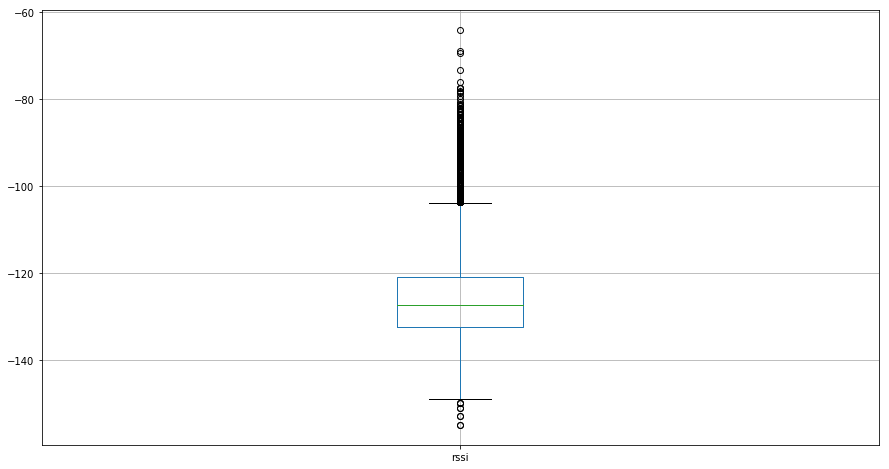

In [13]:
plt.figure(figsize=(15,8))
df_mess_train.boxplot('rssi')
plt.show()

**A l'aide du graphique ci-dessus, les valeurs extrêmes sont facilement identifées (inférieures à -149 et supérieures à -107). Les intervalles représentant chaque label sont alors construits dans cet intervalle. Le nombre/diamètre des intervalles construits est calculé en fonction de la répartition des valeurs (ajusté à 65 catégories/intervalles après validation expérimentale).**
> Note : Les intervalles que nous avons généré, évoluent de façon linéaire contrairement au `rssi` qui lui est en échelle logarithmique. Une amélioration rendant la catégorisation plus proche de la réalité serait de générer des intervalles suivant l'échelles logarithmique.

In [14]:
df_mess_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_train_list.csv')
df_mess_test = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_test_list.csv')
pos_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/pos_train_list.csv')

catdic=np.sort(list(pd.cut(df_mess_train.query('rssi <-107 & rssi>-149')['rssi'],bins=65).unique()))
def set_lab(row):
    i=len(catdic)
    for borne in catdic:
        if borne.right> row:
            return i
        i-=1
    return 1


df_mess_train['rssi']= df_mess_train.rssi.apply(set_lab)

## Modélisation


**Comme décrit précédemment, nous construisons un** `hot encoder`**. L'ensemble des features correspond à l'ensemble des bases (train et test). L'ensembles des observations correspond à l'ensemble des messages aggrégés. Chaque valeur correspond à la réception du message par une base. Différentes variantes ont été testées:**
* **(1, 0) : réception du message sur la base**
* **(rssi, 0) : pondération de la réception d'un message par sa valeur rssi**
* **[(rssi, 0), (lat, 0), (lng, 0)] : ajout de la latitude et la longitude de la base lorsque le message est recu par la base**
* **(label_rssi, 0) : permettant de mieux représenter la variable continue (rssi) sous forme catégorielle**

**Les résultats expérimentaux (non reportés) issus d'une** `Cross Validation` **effectuée sur les algorithmes d'apprentissage** `Random Forest` **et** `Extra Trees` **nous ont guidé vers cette dernière variante.**

In [15]:
def encode_one_variable(val, bsids_add, df):
    X = df.pivot(index='messid', columns='bsid', values=val).fillna(0)
    df_diff = pd.DataFrame(data=np.zeros((X.shape[0],len(bsids_add))), columns=bsids_add, index=X.index)
    X = pd.concat([X, df_diff], axis=1)
    return X.sort_index(ascending=True, axis=1)

def make_all_hot_encoder(df, bsids_add):
    X = encode_one_variable('rssi', bsids_add, df)
    #X = pd.concat([X, encode_one_variable('bs_lat', bsids_add, df)], axis=1)
    #X = pd.concat([X, encode_one_variable('bs_lng', bsids_add, df)], axis=1)
    return X


bsids_add_train = np.setdiff1d(df_mess_test['bsid'], df_mess_train['bsid'])
X = make_all_hot_encoder(df_mess_train, bsids_add_train)

bsids_add_test = np.setdiff1d(df_mess_train['bsid'], df_mess_test['bsid'])
X_test = make_all_hot_encoder(df_mess_test, bsids_add_test)

df_mess_pos = df_mess_train.copy()
df_mess_pos[['lat', 'lng']] = pos_train
Y_true = df_mess_pos.groupby(['messid']).mean()[['lat','lng']]

# Comparaison et tuning des estimateurs 

**Nous avons comparé 3 regresseurs durant ce TP, à savoir,** `Extra Trees`, `Random Forest` **et** `XGBoost`**. Nous nous sommes tourné vers des arbres de décision dû la nature (catégorielle) de nos features. Les deux premiers permettent le traitement de prédictions multi-dimensionnelles.**

**Afin de comparer et fixer les hyperparamètres de nos estimateurs, nous avons effectué une** `Cross Validation` **en LeaveOneDeviceOut (**`LeaveOneGroupOut` **de sklearn). Nous avons aussi ajouté une phase de validation permettant de valider l'approche sur non plus un seul device de moins mais plusieurs (n'ayant jamais été observés). Nous avons fixé cette valeur de manière arbitraire à 10 (représentant 30% du jeu de données). Cette phase a pour but d'estimer les performances de notre modèle pour la compétition sur le jeu de test.**

**Sur** `Extra Trees` **et** `Random Forest`**, nous avons incorporé notre propre fonction de scoring (80 percentilles) à la** `Cross Validation` **de la** `Grid Search`**. En revanche,** `XGBoost` **ne traitant pas la prédiction multi-dimensionnelles, nous prédisons séparement la latitude et la longitude et nous utilisons la fonction de scoring** `RMSE` **pour sélectionner les meilleurs hyperparamètres du modèle.**

**L'ensemble des** `Grid Search` **ont été lancé sur un cluster Spark monté sur les machines de l'école. L'intégration des algorithmes de sklearn dans Spark est effectué par la librairie** `spark_sklearn` **implémentant la fonction** `GridSearchCV` **qui permet de distribuer les jobs sur chaque noeud.**



In [16]:
def make_group(df):
    df_for_group = df.drop_duplicates(subset='messid').reset_index(drop=True)
    df_for_group['deviceID_index'] = df_for_group['did'].apply(lambda x: did_index(x))
    return df_for_group['deviceID_index'].values

nb_did_val = 10
gp_did = make_group(df_mess_train)
mask_train = gp_did > nb_did_val
mask_val = gp_did <= nb_did_val

X_train = X[mask_train]
X_val = X[mask_val]
Y_train = Y_true[mask_train]
Y_val = Y_true[mask_val]

print(f"Dimension de X_train : {X_train.shape}")
print(f"Dimension de X_val : {X_val.shape}")

Dimension de X_train : (4535, 259)
Dimension de X_val : (1533, 259)


In [17]:
#----------------------------------------- Fonctions de scoring ------------------------------------------#
#---------------------------------------------------------------------------------------------------------#
def my_custom_loss_func(y_true, y_pred):

    def vincenty_vec(vec_coord):
        vin_vec_dist = np.zeros(vec_coord.shape[0])
        if vec_coord.shape[1] != 4:
            print('ERROR: Bad number of columns (shall be = 4)')
        else:
            vin_vec_dist = [vincenty(vec_coord[m,0:2], vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
        return vin_vec_dist

    def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
        vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
        err_vec = vincenty_vec(np.transpose(vec_coord))
        return err_vec

    if (np.max(y_pred[:,0]) > 90 or np.min(y_pred[:,0]) < -90):
        return 10000
    err_vec = Eval_geoloc(y_true[:,0], y_true[:,1], y_pred[:,0], y_pred[:,1])
    return np.percentile(err_vec, 80, interpolation='higher')

score_80 = make_scorer(my_custom_loss_func, greater_is_better=False)

In [18]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2], vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

**Le code ci-dessous correspond aux** `Grid Search` **utilisées sur notre cluster Spark pour fixer les hyperparamètres des algorithmes** `Extra Trees`, `Random Forest` **et** `XGBoost`**. Attention, ce code ne compile pas sur un jupyter notebook. Les versions avec les meilleurs hyperparamètres trouvés sont exécutables (voir juste après).**

In [19]:
def crossval(pipeline, parameters, Xtrain, Ytrain, logo):
    my_cv = LeaveOneGroupOut()
    grid_search = GridSearchCV(sc, pipeline, parameters, scoring=score_80, cv=my_cv, verbose=1, n_jobs=-1)    
    grid_search.fit(Xtrain, Ytrain, logo)
    print("Meilleurs parametres :")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search.best_estimator_

In [20]:
#----------------------------------------------- Extra Trees ---------------------------------------------#
#---------------------------------------------------------------------------------------------------------#
pipeline = Pipeline([
    ('reg', ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=1, verbose=1)),
])

parameters = {
    'reg__max_depth':(25, 50, 75, 100, 125, 150, 175, 200, None),
    'reg__max_features':('sqrt','log2','auto'),
    'reg__min_samples_leaf':(1, 2, 3, 4),
    'reg__max_leaf_nodes':(250, 500, 750, 1000, 1250, 1500),
    'reg__bootstrap':(True, False)
}
"""
estimator = crossval(pipeline, parameters, X_train.values, Y_true[mask_train].values, gp_did[mask_train])
y_pred = estimator.predict(X_val.values)

print("Resultat Extra Trees:")
print(my_custom_loss_func(Y_true[mask_val].values, y_pred))
"""

'\nestimator = crossval(pipeline, parameters, X_train.values, Y_true[mask_train].values, gp_did[mask_train])\ny_pred = estimator.predict(X_val.values)\n\nprint("Resultat Extra Trees:")\nprint(my_custom_loss_func(Y_true[mask_val].values, y_pred))\n'

In [21]:
#---------------------------------------------- Random Forest --------------------------------------------#
#---------------------------------------------------------------------------------------------------------#
pipeline = Pipeline([
    ('reg', RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=1)),
])

parameters = {
    'reg__max_depth':(25, 50, 75, 100, 125, 150, 175, 200, None),
    'reg__max_features':('sqrt','log2','auto'),
    'reg__min_samples_leaf':(1, 2, 3, 4),
    'reg__max_leaf_nodes':(250, 500, 750, 1000, 1250, 1500),
    'reg__bootstrap':(True, False)
}
"""
estimator = crossval(pipeline, parameters, X_train.values, Y_true[mask_train].values, gp_did[mask_train])
y_pred = estimator.predict(X_val.values)

print("Resultat Random Forest:")
print(my_custom_loss_func(Y_true[mask_val].values, y_pred))
"""

'\nestimator = crossval(pipeline, parameters, X_train.values, Y_true[mask_train].values, gp_did[mask_train])\ny_pred = estimator.predict(X_val.values)\n\nprint("Resultat Random Forest:")\nprint(my_custom_loss_func(Y_true[mask_val].values, y_pred))\n'

In [22]:
def XGBoost_call(X_train, X_val, Y_train, Y_val):
    paramGrid_lat = {
        'gamma':[0.0001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
        'reg_alpha':[1e-5,1e-4, 1e-3,1e-2, 0.1, 1,10, 100],
        'max_depth':range(100,400,25),
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'learning_rate':[0.1,0.2,0.3,0.5,0.8]
    }
    paramGrid_lng = {
        'gamma':[0.0001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
        'reg_alpha':[1e-5,1e-4, 1e-3,1e-2, 0.1, 1,10, 100],
        'max_depth':range(100,400,25),
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'learning_rate':[0.1,0.2,0.3,0.5,0.8]
    }

    fit_params_lat={"early_stopping_rounds":10, 
                    "eval_metric" : "rmse",
                    "eval_set" : [(X_val, Y_val[:,0])]}
    fit_params_lng={"early_stopping_rounds":10,
                    "eval_metric" : "rmse",
                    "eval_set" : [(X_val, Y_val[:,1])]}

    estimator_lat = xgb.XGBRegressor(random_state=2, n_jobs=-1, n_estimators=300, silent=True)
    estimator_lng = xgb.XGBRegressor(random_state=2, n_jobs=-1, n_estimators=300, silent=True)

    gridsearch_lat = GridSearchCV(sc, estimator_lat, paramGrid_lat, fit_params=fit_params_lat, cv=2, n_jobs=-1)
    gridsearch_lng = GridSearchCV(sc, estimator_lng, paramGrid_lng, fit_params=fit_params_lng, cv=2, n_jobs=-1)

    gridsearch_lat.fit(X_train,Y_train[:,0])
    gridsearch_lng.fit(X_train,Y_train[:,1])

    y_pred_lat = gridsearch_lat.predict(X_val)
    y_pred_lng = gridsearch_lng.predict(X_val)

    err_vec = Eval_geoloc(Y_val[:,0], Y_val[:,1], y_pred_lat, y_pred_lng)
    print("Resultat XGBoost:")
    print(np.percentile(err_vec, 80))
    pd.DataFrame(gridsearch_lat.cv_results_)[['params','rank_test_score','mean_test_score']].to_csv('./xgboost_lat.csv', sep=';')
    pd.DataFrame(gridsearch_lng.cv_results_)[['params','rank_test_score','mean_test_score']].to_csv('./xgboost_lng.csv', sep=';')
    
#XGBoost_call(X_train.values, X_val.values, Y_true[mask_train].values, Y_true[mask_val].values)

## Algorithmes avec les meilleurs hyperparamètres trouvés

In [23]:
def groph(err_vec):
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values)
    plt.figure(figsize=(15,8));
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]);
    plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

### Extra Trees :

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



Resultat Extra Trees:
3465.4491176164906


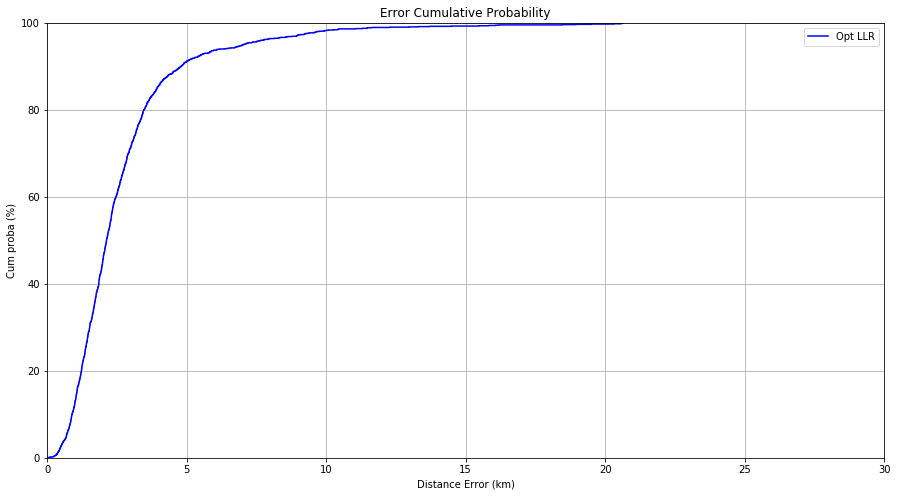

In [24]:
def best_estimator_ET(X_train, X_val, Y_train, Y_val):
    estimator_ET = ExtraTreesRegressor(max_depth=None, bootstrap=False, criterion='mse', n_estimators=200,
                                       max_features='log2', max_leaf_nodes= 750, n_jobs=-1, random_state=2, verbose=1)
    estimator_ET = estimator_ET.fit(X_train, Y_train)
    y_pred = estimator_ET.predict(X_val)

    err_vec = Eval_geoloc(Y_val[:,0], Y_val[:,1], y_pred[:,0], y_pred[:,1])
    print("Resultat Extra Trees:")
    print(np.percentile(err_vec, 80))
    groph(err_vec)

best_estimator_ET(X_train.values, X_val.values, Y_true[mask_train].values, Y_true[mask_val].values)

### Random Forest :

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



Resultat Random Forest:
3367.690764833634


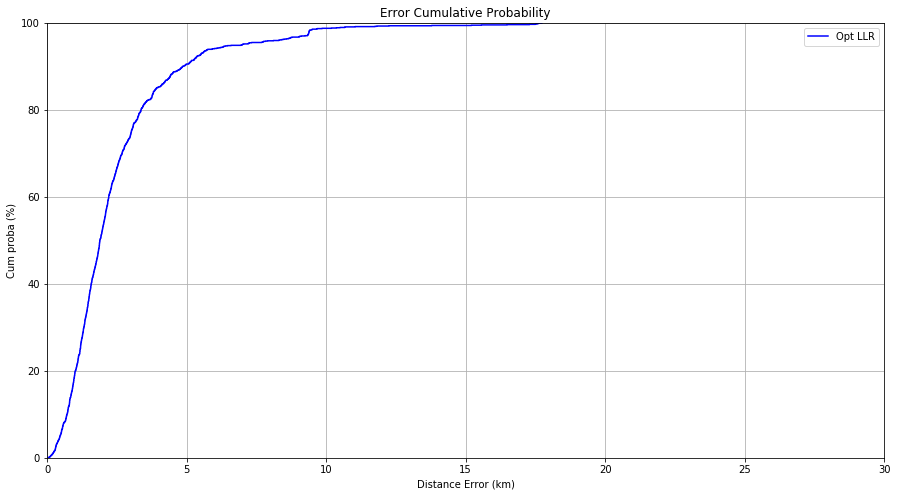

In [25]:
def best_estimator_RF(X_train, X_val, Y_train, Y_val):
    estimator_RF = RandomForestRegressor(max_depth=None, bootstrap=False, criterion='mse', n_estimators=200,
                                       max_features='log2', max_leaf_nodes= 1000, n_jobs=-1, random_state=2, verbose=1)
    estimator_RF = estimator_RF.fit(X_train, Y_train)
    y_pred = estimator_RF.predict(X_val)

    err_vec = Eval_geoloc(Y_val[:,0], Y_val[:,1], y_pred[:,0], y_pred[:,1])
    print("Resultat Random Forest:")
    print(np.percentile(err_vec, 80))
    groph(err_vec)
    return estimator_RF

best_model=best_estimator_RF(X_train.values, X_val.values, Y_true[mask_train].values, Y_true[mask_val].values)

### XGBoost :

[06:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	validation_0-rmse:27.4749
Will train until validation_0-rmse hasn't improved in 10 rounds.
[06:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	validation_0-rmse:19.2196
[06:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	validation_0-rmse:13.4403
[06:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-rmse:9.41484
[06:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-rmse:6.59398
[06:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[5]	validation_0-rmse:4.6215
[06:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 prun

/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



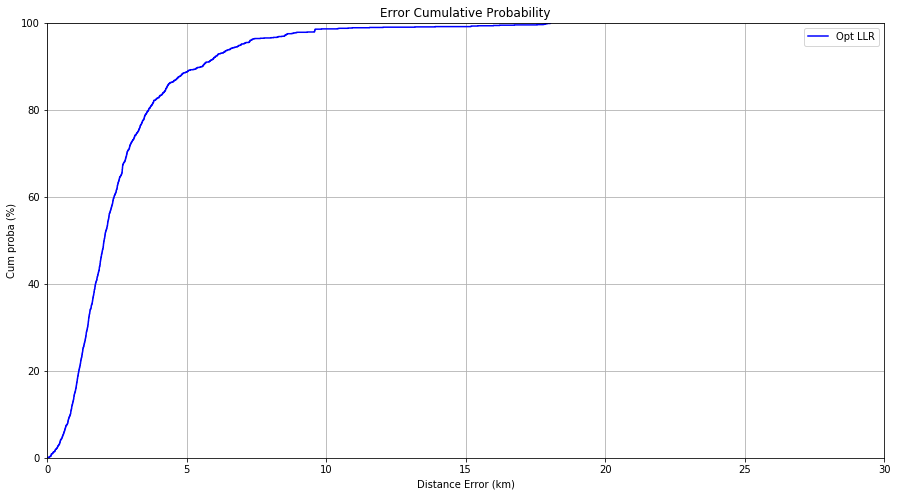

In [26]:
def best_estimator(X_train, X_val, y_train, Y_val):
    estimator_lat = xgb.XGBRegressor(random_state=2, n_jobs=-1, n_estimators=200, silent=False, learning_rate=0.3, gamma=0.01, max_depth=500)
    estimator_lat.fit(X_train, y_train[:,0], early_stopping_rounds=10, eval_set=[(X_val, Y_val[:,0])], verbose=True)

    estimator_lng = xgb.XGBRegressor(random_state=2, n_jobs=-1, n_estimators=200, silent=False, learning_rate=0.3, gamma=0.01, max_depth=500)
    estimator_lng.fit(X_train, y_train[:,1], early_stopping_rounds=10, eval_set=[(X_val,  Y_val[:,1])], verbose=True)

    y_pred_lat = estimator_lat.predict(X_val, ntree_limit=0)
    y_pred_lng = estimator_lng.predict(X_val, ntree_limit=0)

    err_vec = Eval_geoloc(Y_val[:,0], Y_val[:,1], y_pred_lat, y_pred_lng)
    print("Resultat XGBoost:")
    print(np.percentile(err_vec, 80))
    groph(err_vec)  

best_estimator(X_train.values, X_val.values, Y_true[mask_train].values, Y_true[mask_val].values)

## Visualisation des points prédits pour X

In [27]:
pred=best_model.predict(X)
pred_lat=pred[:,0]
pred_lng=pred[:,1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished


In [28]:
X['pred_lat']= pred_lat
X['pred_lng'] =pred_lng
X=X.reset_index(drop=False)

In [29]:
X[['messid','pred_lat','pred_lng']].to_csv('predictionTrain.csv',index=None,header=True)

In [30]:
app = JupyterDash('Visualisation donnée gps')
app.width="1300px"
app.height="900px"




pred = pd.read_csv('predictionTrain.csv')
df = df_mess_train.merge(pos_train, how='left', left_index=True,right_index=True)
df = df.merge(pred,how='left',on='messid')
df['text']=" Message ID " + df["messid"].astype(str)

df['error_distance']=Eval_geoloc( df['lat'], df['lng'], df['pred_lat'], df['pred_lng'])
df['error_copy']=df['error_distance']
did_insight=df.groupby(by='did').agg({'error_distance':'mean','error_copy':'std'}).reset_index(drop=False)


colorscale=[
    'rgb(237,187,153)','rgb(245,203,167)','rgb(250,215,160)','rgb(249,231,156)','rgb(171,235,198)','rgb(165,223,191)',
    'rgb(162,217,206)','rgb(163,228,215)','rgb(174,214,241)','rgb(169,204,227)','rgb(210,180,222)','rgb(255,189,226)',
    'rgb(245,188,177)','rgb(230,176,170)','rgb(39,55,70)','rgb(46,64,83)','rgb(112,123,124)','rgb(131,145,146)',
    'rgb(186,74,0)','rgb(202,111,30)','rgb(214,137,16)','rgb(212,172,15)','rgb(40,180,99)','rgb(34,153,84)',
    'rgb(19,141,117)','rgb(23,165,13)','rgb(46,134,193)','rgb(36,113,163)','rgb(125,60,152)','rgb(136,78,160)',
    'rgb(203,67,53)','rgb(192,57,43)'
]

mapbox_access_token = 'pk.eyJ1IjoiY2h1emUiLCJhIjoiY2pxMHRsY3IzMG9lMjQ4cWprZWJkZTBxMiJ9.gKc50IpMQM2e4skq2NskHw'
app.layout = html.Div([
    html.Link(href='https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css',rel='stylesheet'),
    html.Div(className="row",children=[
        html.Div(className="col-sm-12",children=[
            dcc.Graph(id='visualisation'),
            html.Div(className="row",children=[
                html.Div(className="col-sm-5",children=[
                    html.H2("Device ID"),
                    dcc.Dropdown(
                        id='devicesID',
                        options=getdid(df),
                        multi=True,
                        value=df.did[0]
                    ),
                    html.Div([
                    ],id='test'),
                    html.P('Pour mettre à jour le second graphe clicker sur un point sur la carte de positionnement des devices')
                ]),
                html.Div(className="col-sm-7",children=[
                    dcc.Graph(id='visualisation2'),
                ])

            ]),
        ]),

    ])
])

#Maj du graph principale
@app.callback(
    dash.dependencies.Output('visualisation', 'figure'),
    [Input('devicesID','value')])
def update_vis(DID):
    # requettage sur table des devices à afficher sur une période choisie
    q=""
    if type(DID)==list:
        for device in DID[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(DID[-1])+"'"
    else:
        q+="did =='"+str(DID)+"'"
    devicefil = df.query(q)


    selection=devicefil

    # mise en conformite du device ID
    if type(DID)!=list:
        valnum=DID
        DID=[]
        DID.append(valnum)

    # display des bases de geolocalisation
    traces=[]

    # display des devices
    for deviceID in DID:
        traces.append(go.Scattermapbox(
            lat=selection[(selection.did==deviceID)].lat.values,
            lon=selection[(selection.did==deviceID)].lng.values,
            mode='markers',
            opacity=0.7,
            marker = dict(
                size = 10,
            ),
            name=deviceID,
            text=selection[(selection.did==deviceID)].text.values,
        ))

    # Design
    layout = dict(
        title = 'Positionnement des devices',
        showlegend = True,
        dragmode='lasso',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=np.mean(selection.lat.values),
                lon=np.mean(selection.lng.values)
            ),
            pitch=0,
            zoom=9
        ),
        margin={'l': 10, 'b': 10, 't': 30, 'r': 10},

    )
    return {
        'data': traces,
        'layout': layout
    }

# Maj du second graph via message id
@app.callback(
    dash.dependencies.Output('visualisation2', 'figure'),
    [Input('visualisation', 'selectedData')])
def update_vis2(hoverData):
    try:
        q=""
        for messid in hoverData['points'][:-1]:
            q+=" messid =='"+str(messid['text'].split(' ')[-1])+"' or "
        q+="messid =='"+str(hoverData['points'][-1]['text'].split(' ')[-1])+"'"
        hover=hoverData['points'][0]["text"].split(' ')[-1]
        #q="messid =='"+str(hover)+"'"
        messidfil = df.query(q)
        print(messidfil.columns)
        traces = []
        traces.append(go.Scattermapbox(
            lat=messidfil.bs_lat.values,
            lon=messidfil.bs_lng.values,
            hoverinfo='none',
            mode='markers',
            name="Stations",
            opacity=0.7,
            marker = dict(
                symbol="information"
            ),
            text=basepos.index.values
        ))
        print(messidfil)
        messidfil =messidfil.groupby(by='messid').agg({'lat':'mean', 'lng':'mean', 'pred_lat':'mean', 'pred_lng':'mean'}).reset_index(drop=False)
        print(messidfil)
        ind=0
        for row in messidfil.values:
            print(row)
            if ind>=len(colorscale):
                break
            traces.append(go.Scattermapbox(
                lat=[row[1]],
                lon=[row[2]],
                name=row[0],
                mode='markers',
                hoverinfo='none',
                opacity=1,
                marker = dict(
                    size = 10,
                    color= colorscale[ind]
                ),
                legendgroup= row[0]
            ))

            traces.append(go.Scattermapbox(
                lat=[row[3]],
                lon=[row[4]],
                mode='markers',
                name=row[0],
                showlegend=False,
                opacity=1,
                marker = dict(
                    size=20,
                    color= colorscale[ind]
                ),
                legendgroup= row[0]
            ))
            ind+=1

        # Design
        layout = dict(
            title = 'messid = '+str(hover),
            showlegend = True,
            mapbox=dict(
                accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(
                    lat=np.mean(messidfil.lat.values),
                    lon=np.mean(messidfil.lng.values)
                ),
                pitch=0,
                zoom=12
            ),
            margin={'l': 10, 'b': 10, 't': 30, 'r': 10},
        )

        return {
            'data': traces,
            'layout': layout
        }
    except:
        return {}




# Test des composants ajoutés
@app.callback(
    Output('test', 'children'),
    [Input('devicesID','value')]
)
def test(typeD):
    q=""
    if type(typeD)==list:
        for device in typeD[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(typeD[-1])+"'"
    else:
        q+="did =='"+str(typeD)+"'"
    rq=did_insight.query(q)
    bodytab=[]
    for row in rq.values:
        bodytab.append(html.Tr([
            html.Th([row[0]]),
            html.Th([row[1]]),
            html.Th([row[2]]),
        ]))
        print(row)
    madiv=html.Table([
        html.Thead([
            html.Tr([
                html.Th(["Device ID"]),
                html.Th(["Erreur moyenne"]),
                html.Th(["Variance de l'erreur"]),
            ])
        ]),
        html.Tbody(children=bodytab)
    ],className="table table-striped")



    return [madiv]

app

/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



## Prédiction sur le jeu de test

In [31]:
pred=best_model.predict(X_test)
pred_lat=pred[:,0]
pred_lng=pred[:,1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished


In [32]:
X_test['lat']= pred_lat
X_test['lng'] =pred_lng
X_test=X_test.reset_index(drop=False)
X_test[['messid','lat','lng']].to_csv('pred_pos_test_list.csv',index=None)
X_test[['messid','lat','lng']].shape

(5294, 3)